In [1]:
#import all the necessary libraries
import os
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

if not os.path.isdir('models'):
    os.mkdir('models')

import tensorflow as tf    
print('TensorFlow version:', tf.__version__)

from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input, Lambda
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input
from sklearn.utils import shuffle
from keras.datasets import cifar10

TensorFlow version: 2.2.0


Using TensorFlow backend.


In [0]:
#import Inception model
# Inception V3 isdesigned to intake 299X299 images. We shall use smaller images for faster training which will speed up training. Keras v2.0.9 supports down to 120x120x3
input_size = 120

# Using Inception with ImageNet pre-trained weights
inception = InceptionV3(weights='imagenet', include_top=False,
                        input_shape=(input_size,input_size,3))

#make the layers non-trainable
for layer in inception.layers:
        layer.trainable = False

In [4]:
inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 120, 120, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 59, 59, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 59, 59, 32)   96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 59, 59, 32)   0           batch_normalization_95[0][0]     
_______________________________________________________________________________________

In [0]:
#input dimensions of cifar-10 images
cifar_input = Input(shape=(32,32,3))

# Re-size the cifar input  to match with that of inception's input
resized_input = Lambda(lambda image: tf.image.resize(image, (input_size, input_size)))(cifar_input)

# Feed the re-sized input into Inception model
inp = inception(resized_input)

In [0]:

#Adding the GlobalAveragePooling2D layer, then a dense layer with 512 units and an output layer with softmax activation
x = GlobalAveragePooling2D()(inp)
x = Dense(512, activation = 'relu')(x)
predictions = Dense(10, activation = 'softmax')(x)

In [7]:


# Creates the model
model = Model(inputs=cifar_input, outputs=predictions)

# Compile the model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Check the summary of this new model to confirm the architecture
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 120, 120, 3)       0         
_________________________________________________________________
inception_v3 (Model)         (None, 2, 2, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 22,857,002
Trainable params: 1,054,218
Non-trainable params: 21,802,784
_______________________________________

In [0]:
#load the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

# Shuffle the training & test data
x_train, y_train = shuffle(x_train, y_train)
x_test, y_test = shuffle(x_test, y_test)

# We are only going to use the first 10,000 images for faster training
# And only the first 2,000 images from the test set
x_train = x_train[:10000]
y_train = y_train[:10000]
x_test = x_test[:2000]
y_test = y_test[:2000]

In [0]:
#running the data through datagenerators for faster training
datagen = ImageDataGenerator(preprocessing_function=preprocess_input).flow(x_train, y_train, batch_size=batch_size)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input).flow(x_test, y_test, batch_size=batch_size)

In [62]:
batch_size = 32
epochs = 5
# Note: we aren't using callbacks here since we only are using 5 epochs to conserve GPU time
h = model.fit_generator(datagen, 
                    steps_per_epoch=datagen.n/batch_size, epochs=epochs, verbose=1, 
                    validation_data=val_datagen,
                    validation_steps=val_datagen.n/batch_size)

Epoch 1/5
313/312 [==============================] - 315s 1s/step - loss: 1.0650 - accuracy: 0.6309 - val_loss: 2.4980 - val_accuracy: 0.6190
Epoch 2/5
313/312 [==============================] - 311s 994ms/step - loss: 1.0230 - accuracy: 0.6376 - val_loss: 1.4274 - val_accuracy: 0.6345
Epoch 3/5
313/312 [==============================] - 315s 1s/step - loss: 1.0108 - accuracy: 0.6419 - val_loss: 2.7300 - val_accuracy: 0.6255
Epoch 4/5
313/312 [==============================] - 313s 999ms/step - loss: 0.9917 - accuracy: 0.6513 - val_loss: 1.2457 - val_accuracy: 0.5930
Epoch 5/5
313/312 [==============================] - 312s 998ms/step - loss: 0.9625 - accuracy: 0.6648 - val_loss: 1.7112 - val_accuracy: 0.6200


In [0]:
#create a predictions array
preds = model.predict(x_test)

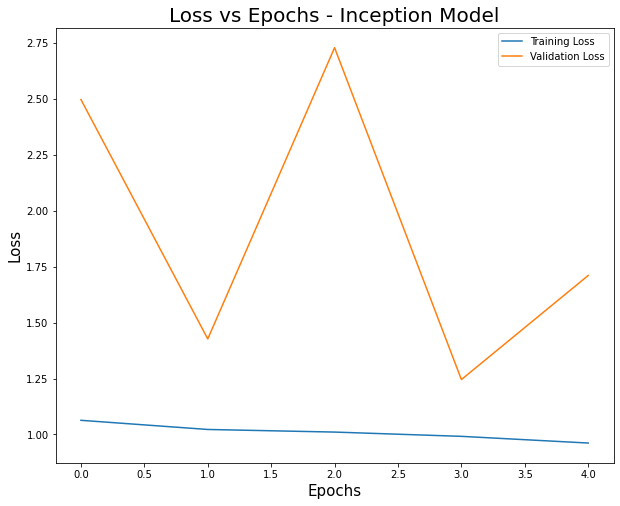

In [116]:
#Plot the loss for both training and validation

plt.figure(figsize = (10,8))
plt.plot(range(epochs), h.history['loss'], label = "Training Loss")
plt.plot(range(epochs), h.history['val_loss'], label = "Validation Loss")
plt.xlabel("Epochs", fontsize = 15)
plt.ylabel("Loss", fontsize = 15)
plt.title("Loss vs Epochs - Inception Model", fontsize = 20)
plt.legend()
plt.show()

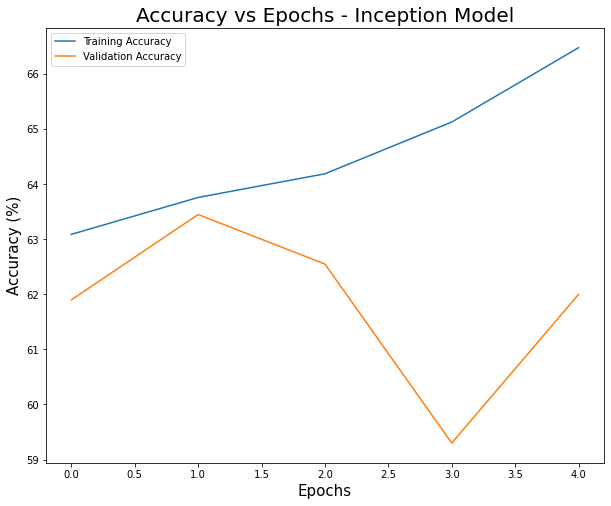

In [115]:
#Plot the accuracy for both training and validation

plt.figure(figsize = (10,8))
plt.plot(range(epochs), np.array(h.history['accuracy'])*100, label = "Training Accuracy")
plt.plot(range(epochs), np.array(h.history['val_accuracy'])*100, label = "Validation Accuracy")
plt.xlabel("Epochs", fontsize = 15)
plt.ylabel("Accuracy (%)", fontsize = 15)
plt.title("Accuracy vs Epochs - Inception Model", fontsize = 20)
plt.legend()
plt.show()

The validation accuracy peaked at epoch 1 (63.45%)

In [0]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

#define a function to randomly plot 10 images with their labels
def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names[np.argmax(y[i])], color=col)     
        
    plt.show()

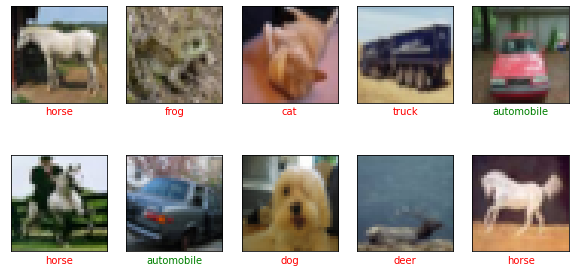

In [114]:
#for inception model, show random predictions
show_random_examples(x_test, y_test, preds)

In [96]:
#import the resnet50 model. Set it to read inputs of 120X120X3
from keras.applications.resnet50 import ResNet50
resnet = ResNet50(include_top=False, weights=None, input_shape=(120,120,3))
print(type(resnext))

#make the layers non-trainable
for layer in resnet.layers:
        layer.trainable = False
resnet.summary()

<class 'keras.engine.training.Model'>
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 120, 120, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 126, 126, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 60, 60, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 60, 60, 64)   256         conv1[0][0]                      
_____________________________________________________

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [0]:
# Feed the re-sized input into resnet model
resnet = resnet(resized_input)

x = GlobalAveragePooling2D()(resnet)

x = Dense(512, activation = 'relu')(x)
predictions = Dense(10, activation = 'softmax')(x)

In [99]:
# Creates the model
model_resnet = Model(inputs=cifar_input, outputs=predictions)

# Compile the model
model_resnet.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Check the summary of this new model to confirm the architecture
model_resnet.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 120, 120, 3)       0         
_________________________________________________________________
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5130      
Total params: 24,641,930
Trainable params: 1,054,218
Non-trainable params: 23,587,712
_______________________________________

In [0]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input).flow(x_train, y_train, batch_size=batch_size)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input).flow(x_test, y_test, batch_size=batch_size)

In [101]:
batch_size = 32
epochs = 5

#fit the model. Use fit_generator for faster training
h_resnet = model_resnet.fit_generator(datagen, 
                    steps_per_epoch=datagen.n/batch_size, epochs=epochs, verbose=1, 
                    validation_data=val_datagen,
                    validation_steps=val_datagen.n/batch_size)

Epoch 1/5
313/312 [==============================] - 667s 2s/step - loss: 2.5017 - accuracy: 0.1345 - val_loss: 98.0632 - val_accuracy: 0.1025
Epoch 2/5
313/312 [==============================] - 664s 2s/step - loss: 2.2392 - accuracy: 0.1523 - val_loss: 104.3701 - val_accuracy: 0.1020
Epoch 3/5
313/312 [==============================] - 668s 2s/step - loss: 2.2351 - accuracy: 0.1530 - val_loss: 42.6273 - val_accuracy: 0.1040
Epoch 4/5
313/312 [==============================] - 669s 2s/step - loss: 2.2294 - accuracy: 0.1482 - val_loss: 118.7870 - val_accuracy: 0.1020
Epoch 5/5
313/312 [==============================] - 667s 2s/step - loss: 2.2254 - accuracy: 0.1541 - val_loss: 99.3189 - val_accuracy: 0.1020


In [0]:
preds_resnet = model_resnet.predict(x_test)

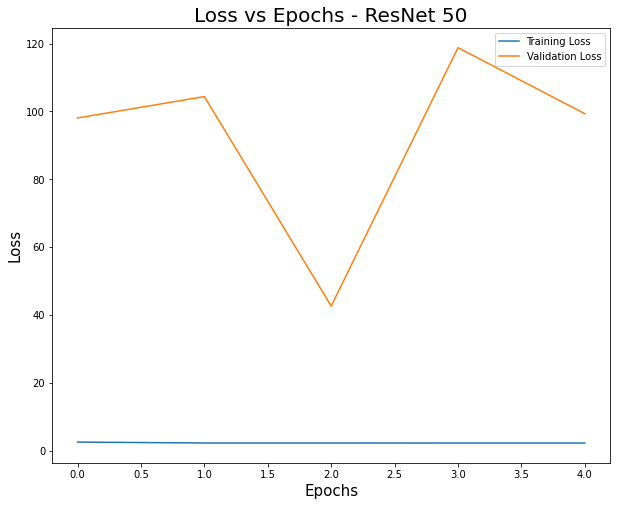

In [113]:
#plot the loss

plt.figure(figsize = (10,8))
plt.plot(range(epochs), h_resnet.history['loss'], label = "Training Loss")
plt.plot(range(epochs), h_resnet.history['val_loss'], label = "Validation Loss")
plt.xlabel("Epochs", fontsize = 15)
plt.ylabel("Loss", fontsize = 15)
plt.title("Loss vs Epochs - ResNet 50", fontsize = 20)
plt.legend()
plt.show()

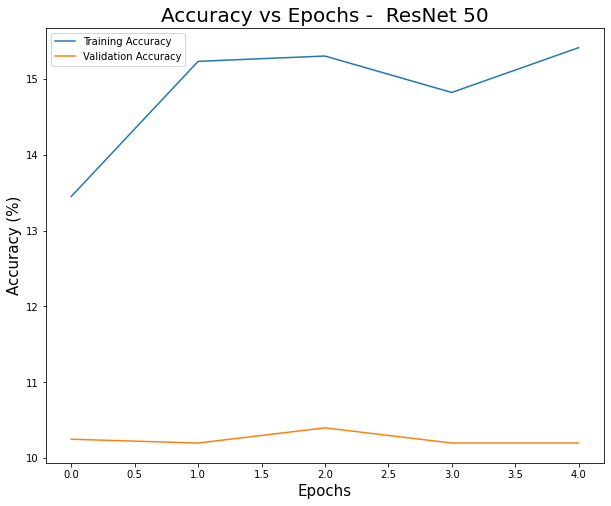

In [112]:
#  Plot the accuracy for both training and validation

plt.figure(figsize = (10,8))
plt.plot(range(epochs), np.array(h_resnet.history['accuracy'])*100, label = "Training Accuracy")
plt.plot(range(epochs), np.array(h_resnet.history['val_accuracy'])*100, label = "Validation Accuracy")
plt.xlabel("Epochs", fontsize = 15)
plt.ylabel("Accuracy (%)", fontsize = 15)
plt.title("Accuracy vs Epochs -  ResNet 50", fontsize = 20)
plt.legend()
plt.show()

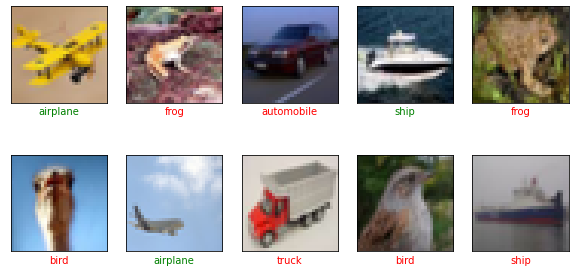

In [105]:
#print random examples for resnet 50 model
show_random_examples(x_test, y_test, preds_resnet)

#We can see that only 10% of the cases are correctly classfied